In [114]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

In [124]:
def run_tests(clf, name, X_train, y_train, X_test, y_test):
    t0 = time.time()
    trained = clf.fit(X_train, y_train)
    t1 = time.time()
    pred1 = trained.predict(X_test)
    t2 = time.time()
    pa1 = trained.predict_proba(X_test)[:, 1]

    pred2 = trained.predict(X_train)
    pa2 = trained.predict_proba(X_train)[:, 1]

    # pred3 = trained.predict(X_val)
    # pa3 = trained.predict_proba(X_test)[:, 1]

    met1 = get_metrics(name + ' X_test', y_test, pred1, pa1)
    met2 = get_metrics(name + ' X_train', y_train, pred2, pa2)
    # met3 = get_metrics(name + ' X_val', y_val, pred3, pa3)

    print(f"({name}) Time to train", t1 - t0)
    print(f"({name}) Avg time to classify", (t2 - t1) / X_test.shape[0])
    print(f"({name}) (X_test) accuracy, precision, recall, specificity, AUROC", met1)
    print(f"({name}) (X_train) accuracy, precision, recall, specificity, AUROC", met2)
    # print(f"({name}) (X_val) accuracy, precision, recall, specificity, AUROC", met3)

In [125]:
def get_metrics(name, y_test, y_pred, proba):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fn + fp)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    specificity = tn / (tn+fp)
    roc_auc = roc_auc_score(y_test, proba)
    fpr, tpr, thresholds = roc_curve(y_test, proba, pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(name)
    plt.show()

    return accuracy, precision, recall, specificity, roc_auc

In [100]:
X = pd.read_csv('train/train_demos.csv')

In [101]:
X.head()

,patient_id,age,gender,admittime,insurance,marital_status,ethnicity
0,p100001,56,M,2174-05-26 08:21:00,Other,MARRIED,WHITE
1,p100002,91,F,2176-11-25 21:28:00,Medicare,WIDOWED,BLACK/AFRICAN AMERICAN
2,p100004,83,F,2154-04-24 03:15:00,Other,DIVORCED,WHITE
3,p100006,72,M,2131-02-27 15:34:00,Medicare,NaN,UNKNOWN
4,p100007,59,M,2183-08-18 12:20:00,Other,MARRIED,WHITE


In [102]:
X.describe()

,age
count,13708.000000
mean,62.349577
std,16.758205
min,18.000000
25%,52.000000
50%,63.000000
75%,75.000000
max,91.000000


In [103]:
pd.unique(X['gender'])

array(['M', 'F'], dtype=object)

In [104]:
X = X.set_index('patient_id')

In [105]:
cat = ['gender', 'insurance', 'marital_status', 'ethnicity']

In [106]:
enc = OneHotEncoder(handle_unknown='ignore')
X_encoded = enc.fit_transform(X[cat])
X_encoded = pd.DataFrame.sparse.from_spmatrix(X_encoded)
X_encoded.index = X.index
X_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
patient_id,,,,,,,,,,,,,,,,,,
p100001,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0
p100002,1.0,0,0,1.0,0,0,0,0,1.0,0,0,0,1.0,0,0,0,0,0
p100004,1.0,0,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0
p100006,0,1.0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0
p100007,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p117116,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0
p117124,0,1.0,0,1.0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0
p117127,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0


In [107]:
X = pd.concat([X.drop(cat, axis=1), X_encoded], axis=1)

In [108]:
X

,age,admittime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
patient_id,,,,,,,,,,,,,,,,,,,,
p100001,56,2174-05-26 08:21:00,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0
p100002,91,2176-11-25 21:28:00,1.0,0,0,1.0,0,0,0,0,1.0,0,0,0,1.0,0,0,0,0,0
p100004,83,2154-04-24 03:15:00,1.0,0,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0
p100006,72,2131-02-27 15:34:00,0,1.0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0
p100007,59,2183-08-18 12:20:00,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p117116,64,2189-10-30 16:33:00,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0
p117124,73,2132-04-24 17:25:00,0,1.0,0,1.0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0
p117127,42,2141-04-21 17:05:00,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0


In [109]:
X['admittime'] = X.apply(lambda x: time.mktime(pd.Timestamp(x['admittime']).timetuple()), axis=1)

In [111]:
X['admittime'] = X['admittime'] - X['admittime'].min()

In [116]:
X[['age', 'admittime']] = preprocessing.StandardScaler().fit_transform(X[['age', 'admittime']])

In [117]:
X

,age,admittime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
patient_id,,,,,,,,,,,,,,,,,,,,
p100001,-0.378907,0.717514,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0
p100002,1.709698,0.821455,1.0,0,0,1.0,0,0,0,0,1.0,0,0,0,1.0,0,0,0,0,0
p100004,1.232302,-0.116345,1.0,0,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0
p100006,0.575884,-1.077402,0,1.0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0
p100007,-0.199884,1.100640,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p117116,0.098488,1.358073,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0
p117124,0.635558,-1.029439,0,1.0,0,1.0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0
p117127,-1.214350,-0.656220,0,1.0,0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0


In [127]:
y = pd.read_csv('train/train_labels.csv')
y = y.set_index('patient_id')
X.columns = X.columns.astype(str)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Lib

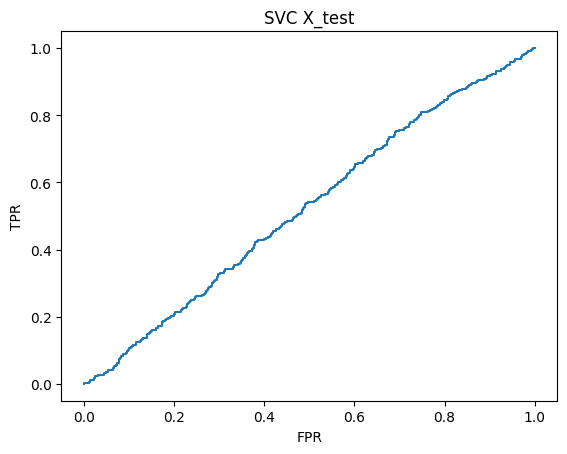

/var/folders/w7/p5hccgr909d_v0mnz70pzwch0000gn/T/ipykernel_31870/1136690420.py:4: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp+fp)


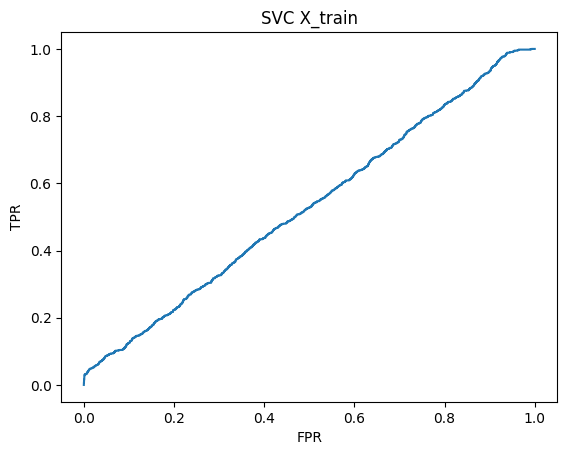

(SVC) Time to train 12.575026988983154
(SVC) Avg time to classify 7.634201862389749e-05
(SVC) (X_test) accuracy, precision, recall, specificity, AUROC (0.9028304639626495, nan, 0.0, 1.0, 0.5229689935572288)
(SVC) (X_train) accuracy, precision, recall, specificity, AUROC (0.9055539344421749, nan, 0.0, 1.0, 0.5301424445326941)


In [133]:

# svm
svc = svm.SVC(kernel='poly', probability=True)

run_tests(svc, 'SVC', X_train, y_train, X_test, y_test)
